In [76]:
import pandas as pd, re, time, itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split,cross_val_score,KFold,cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score,confusion_matrix,precision_recall_curve,roc_curve
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm,tree
import nltk
from nltk.corpus import stopwords
#from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud, STOPWORDS

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [5]:
np.random.seed(40)

## Load Data

In [6]:
df = pd.read_csv("data.csv")
df = df.reindex(np.random.permutation(df.index)) ## shuffle the dataframe
df.head()

,content,sentiment
12630,How many incomplete sentences can you fit on o...,0
24859,"Buggy, Buggy, Buggy! Unplayable at release., I...",0
22131,"English Crossover? DREAM ON!!, The English son...",0
85,"Jobst UltraSheer Knee High Stockings, Does a v...",1
590,Australia's best-kept secret is an absolute tr...,1


## Exploratory Data Analysis - Part1

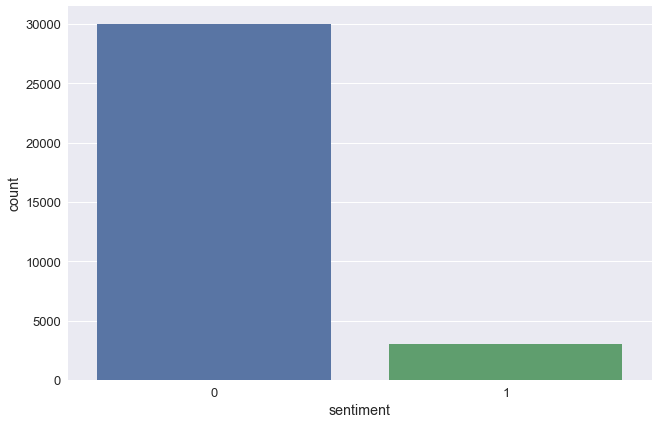

In [8]:
# Visualize the class distribution
sns.factorplot(x="sentiment", data=df, kind="count", size=6, aspect=1.5, palette="deep")
plt.show();

In [9]:
df.info() ## Other Information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33000 entries, 12630 to 11590
Data columns (total 2 columns):
content      33000 non-null object
sentiment    33000 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.0+ MB


In [10]:
df.isnull().sum() # Check if there is any null values

content      0
sentiment    0
dtype: int64

### Visualize positive and negative words in the content

Positive Words


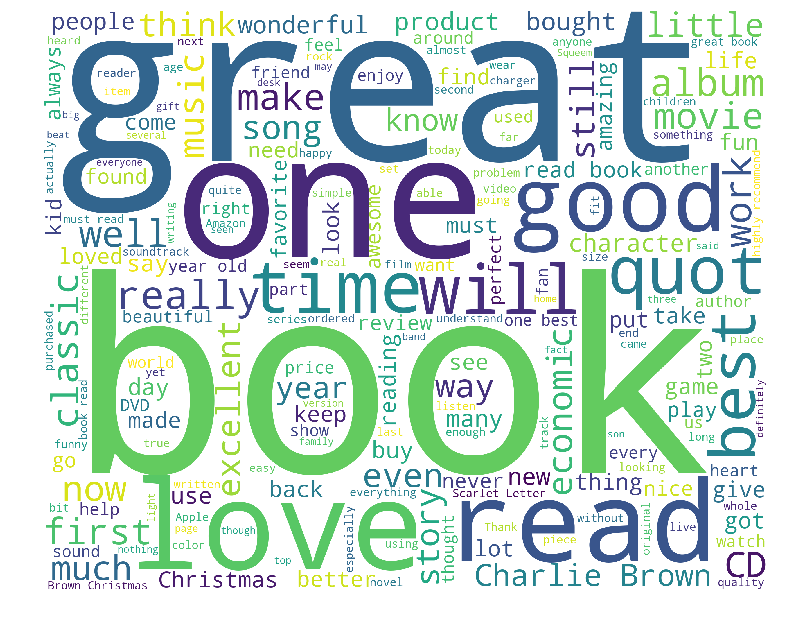

Negative Words


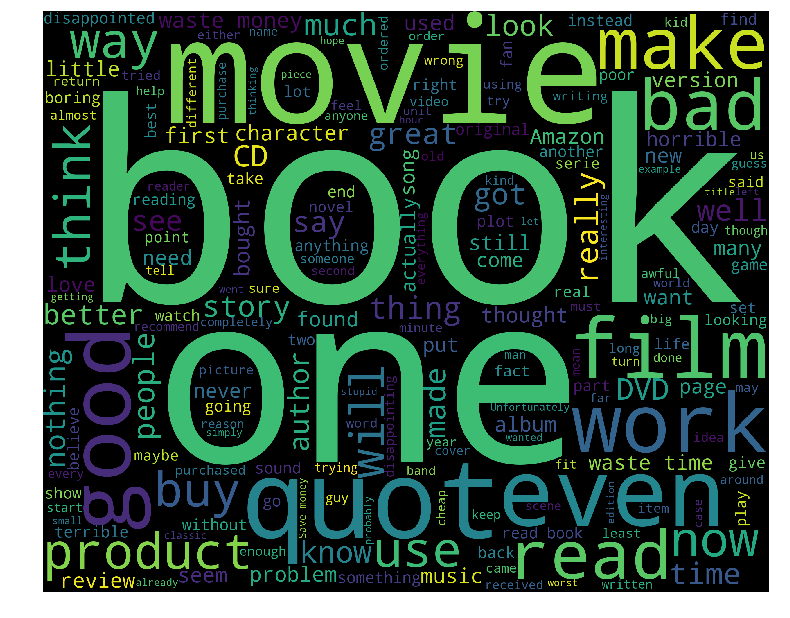

In [14]:
sent_pos = df[df['sentiment']== 1]
sent_neg = df[df['sentiment'] == 0]

text_pos = sent_pos['content']
text_neg = sent_neg['content']

def word_cloud(text, color = 'black'):
    words = ' '.join(text)
    clean_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(clean_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print('Positive Words')
word_cloud(text_pos, color = 'white')

print('Negative Words')
word_cloud(text_neg)

## Data Cleaning

In [27]:
def clean_text(text, remove_stopwords= True):
    text = text.lower()

    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'\d+', 'number', text)
    text = re.sub(r'[_"\-;%()|+&=*%,.!?:#$@â£\[\]/]', ' ', text)

    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    
    return text

In [28]:
content = df.content

clean_content = []
for i in content:
    clean_content.append(clean_text(i))

In [29]:
len(clean_content)

33000

In [31]:
print('Clean Content', '\n', clean_content[0:2] )

Clean Content 
 ["many incomplete sentences fit one page really wanted like one worst written fantasies i've ever read apparently little money expended editing luna books writing awkward repetitive dull much simply wastes space insults reader's intelligence i'd expect talented eighth grader write multiple incomplete sentences every page descriptions lackluster cliched dialogue dull staccato disappointing book edited adequately author challenged tighten writing could turned something readable actually good i'm astonished positive promotional comments jacket wonder reviewers actually read book", "buggy buggy buggy unplayable release could give game number star i've still able play number minutes without locking crashing losing sound mouse controls owning month yet finish scenario skirmish simply unplayable right read microsoft aoenumber forums get information game poorly tested nearly everyone issues patch expected sometime word es though would strongly suggest waiting purchase game save

In [36]:
df['clean_content'] = clean_content
df.head()

,content,sentiment,clean_content
12630,How many incomplete sentences can you fit on o...,0,many incomplete sentences fit one page really ...
24859,"Buggy, Buggy, Buggy! Unplayable at release., I...",0,buggy buggy buggy unplayable release could giv...
22131,"English Crossover? DREAM ON!!, The English son...",0,english crossover dream english song bailamos ...
85,"Jobst UltraSheer Knee High Stockings, Does a v...",1,jobst ultrasheer knee high stockings good job ...
590,Australia's best-kept secret is an absolute tr...,1,australia's best kept secret absolute treasure...


## Exploratory Data Analysis - Part2

In [32]:
## Check the distribution of content length
content_length = []
for sent in clean_content:
    if len(sent) == 1:
        content_length.append(len(sent))
    else:
        word_count = sent.split()
        content_length.append(len(word_count))
    
df1 = pd.DataFrame(content_length, columns=['length_counts'])
df1.describe()

,length_counts
count,33000.000000
mean,35.461848
std,18.864771
min,1.000000
25%,20.000000
50%,32.000000
75%,49.000000
max,179.000000


In [34]:
## Count data that has less than 2 words
df2 = df1[df1['length_counts'] <= 2]
rm_items = df2.index.values.tolist()
len(rm_items)

37

## Splitting the training and testing data

In [128]:
# Splitting the dataset into train and test set
X = df.clean_content
y = df.sentiment

vect = CountVectorizer(binary=True)
X_vect = vect.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_vect,y,test_size = 0.2, random_state=40, stratify = y)

In [129]:
X_train[0:5]

<5x52470 sparse matrix of type '<class 'numpy.int64'>'
	with 116 stored elements in Compressed Sparse Row format>

In [130]:
y_train[0:5]

29738    0
25635    0
19922    0
17155    0
15043    0
Name: sentiment, dtype: int64

## Evaluation Metrics Function

In [52]:
#Defining the confusion matrix function
# This code was taked from scikit-learn documentation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Using Success and Failure for 0 and 1    
class_names = ['Success','Failure']

## Train Model and Visualize the Evaluation Metrics with imbalance Data

### Classifier 1 - Logistic Regression

Logistic Accuracy is 0.97
Cross Validation Score = 0.96
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      6000
          1       0.88      0.71      0.79       600

avg / total       0.96      0.97      0.96      6600

--- 8.82848596572876 seconds ---


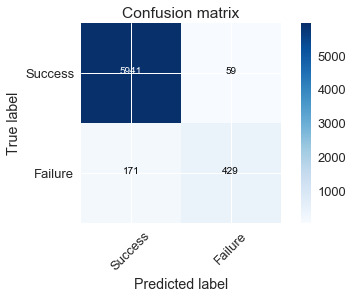

In [131]:
start_time = time.time()

#Logistic Regression Classifier
LR = LogisticRegression()
LR.fit(X_train,y_train)
print ("Logistic Accuracy is %2.2f" % accuracy_score(y_val, LR.predict(X_val)))

# Cross-validation Score
score_lr = cross_val_score(LR, X_vect, y, cv=10).mean()
print("Cross Validation Score = %2.2f" % score_lr)
y_pred = LR.predict(X_val)
print(classification_report(y_val, y_pred))

# Confusion matrix for LR
cm = confusion_matrix(y_val,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

print("--- %s seconds ---" % (time.time() - start_time))

### Classifier 2 - Multinomial Naive Bayes

Logistic Accuracy is 0.94
Cross Validation Score = 0.94
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      6000
          1       0.79      0.45      0.58       600

avg / total       0.93      0.94      0.93      6600

--- 0.584252119064331 seconds ---


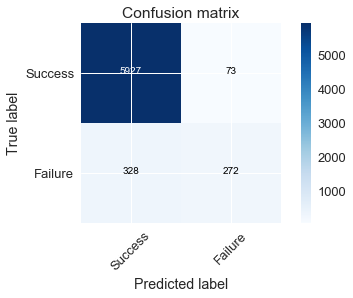

In [77]:
start_time = time.time()
# Naive bayes classifier
nb = MultinomialNB()
nb.fit(X_train, y_train)
print ("Logistic Accuracy is %2.2f" % accuracy_score(y_val, nb.predict(X_val)))

# Cross-validation Score
score_nb = cross_val_score(nb, X_vect, y, cv=10).mean()
print("Cross Validation Score = %2.2f" % score_nb)

y_pred = nb.predict(X_val)
print(classification_report(y_val, y_pred))

# Confusion matrix for LR
cm = confusion_matrix(y_val,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

print("--- %s seconds ---" % (time.time() - start_time))

### Classifier 3 - Random Forest

Random Forest Accuracy is 0.95
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      6000
          1       0.91      0.51      0.65       600

avg / total       0.95      0.95      0.94      6600

--- 662.5832970142365 seconds ---


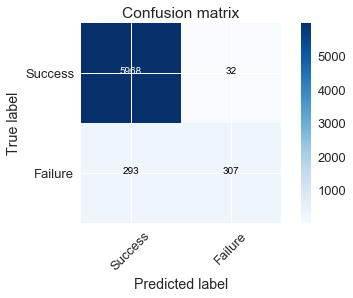

In [73]:
start_time = time.time()

#Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=10,class_weight="balanced")
rfc.fit(X_train, y_train)
print ("Random Forest Accuracy is %2.2f" % accuracy_score(y_val, rfc.predict(X_val)))
y_pred = rfc.predict(X_val)
print(classification_report(y_val,y_pred ))
#Confusion Matrix for Random Forest
cm = confusion_matrix(y_val,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

print("--- %s seconds ---" % (time.time() - start_time))

## Treat imbalance data

In [79]:
from imblearn.over_sampling import SMOTE

In [80]:
sm = SMOTE()

X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [81]:
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))

[(0, 24000), (1, 24000)]


## Train and Evalute Model with balance data

### Classifier 2 - Multinomial Naive Bayes

Logistic Accuracy is 0.96
Cross Validation Score = 0.94
             precision    recall  f1-score   support

          0       0.99      0.97      0.98      6000
          1       0.74      0.85      0.80       600

avg / total       0.96      0.96      0.96      6600

--- 0.6175100803375244 seconds ---


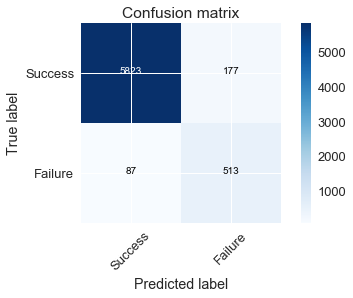

In [82]:
start_time = time.time()
# Naive bayes classifier
nb = MultinomialNB()
nb.fit(X_train_res, y_train_res)
print ("Logistic Accuracy is %2.2f" % accuracy_score(y_val, nb.predict(X_val)))

# Cross-validation Score
score_nb = cross_val_score(nb, X_vect, y, cv=10).mean()
print("Cross Validation Score = %2.2f" % score_nb)
y_pred = nb.predict(X_val)
print(classification_report(y_val, y_pred))

# Confusion matrix for LR
cm = confusion_matrix(y_val,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

print("--- %s seconds ---" % (time.time() - start_time))

### Classifier 1 -  Logistic Regression

Logistic Accuracy is 0.95
Cross Validation Score = 0.96
             precision    recall  f1-score   support

          0       0.98      0.97      0.97      6000
          1       0.72      0.79      0.75       600

avg / total       0.96      0.95      0.95      6600

--- 8.603971242904663 seconds ---


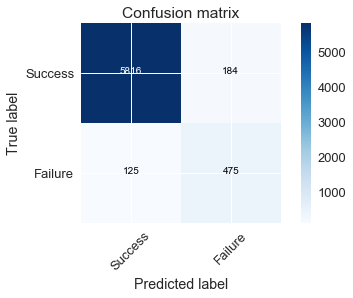

In [83]:
start_time = time.time()

#Logistic Regression Classifier
LR = LogisticRegression()
LR.fit(X_train_res,y_train_res)
print ("Logistic Accuracy is %2.2f" % accuracy_score(y_val, LR.predict(X_val)))

# Cross-validation Score
score_lr = cross_val_score(LR, X_vect, y, cv=10).mean()
print("Cross Validation Score = %2.2f" % score_lr)
y_pred = LR.predict(X_val)
print(classification_report(y_val, y_pred))

# Confusion matrix for LR
cm = confusion_matrix(y_val,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

print("--- %s seconds ---" % (time.time() - start_time))

## Analysis Results before and after balancing the data

The ratio of positive and negative class are quite similar in training and validating data before balance the data. So, there is not much change in the results before and after balancing the data.

(array([24000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2400.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

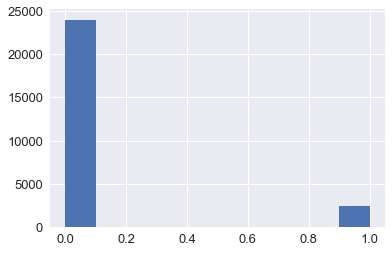

In [84]:
plt.hist(y_train)

(array([6000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         600.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

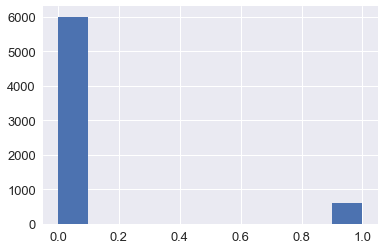

In [85]:
plt.hist(y_val)

(array([24000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 24000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

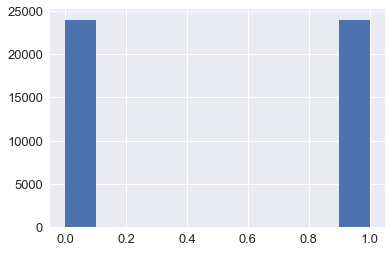

In [86]:
plt.hist(y_train_res)

## Deep learning Approach - RNN/LSTM with Keras

In [87]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [90]:
# Tokenize and vectorize the data
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['clean_content'].values)
X_new = tokenizer.texts_to_sequences(df['clean_content'].values)
X_new = pad_sequences(X_new)

In [93]:
X_new[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,   45, 1824, 1678,  251,    3,  225,   17,  199,    5,
          3,   32,   89,   59,   21,    8,  830,   66,   14, 1359,   48,
        155, 1402,  438,   19,  265,  807, 1825,  274,  451, 1629,  284,
       1239, 1824, 1678,   83,  225, 1234,  707,  438,  224,    2, 1207,
         97,  155,   22,  463,   64,   99,    9,   35,  911, 1412, 1891,
        551,  543,   99,    8,    2], dtype=int32)

In [91]:
## Build Model
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 82, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 82, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [92]:
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X_new,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(26400, 82) (26400, 2)
(6600, 82) (6600, 2)


In [94]:
batch_size = 64
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
 - 115s - loss: 0.1928 - acc: 0.9362
Epoch 2/10
 - 113s - loss: 0.1024 - acc: 0.9638
Epoch 3/10
 - 115s - loss: 0.0852 - acc: 0.9689
Epoch 4/10
 - 119s - loss: 0.0722 - acc: 0.9742
Epoch 5/10
 - 126s - loss: 0.0619 - acc: 0.9782
Epoch 6/10
 - 125s - loss: 0.0567 - acc: 0.9789
Epoch 7/10
 - 114s - loss: 0.0480 - acc: 0.9837
Epoch 8/10
 - 116s - loss: 0.0440 - acc: 0.9842
Epoch 9/10
 - 129s - loss: 0.0339 - acc: 0.9883
Epoch 10/10
 - 125s - loss: 0.0342 - acc: 0.9881


## Evaluation Metrics

In [98]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("accuracy: %.2f" % (acc))

score: 0.22
acc: 0.95


## Predict Output with DL sequence model

In [108]:
x = ['The Worst!, A complete waste of time.']
x1 = tokenizer.texts_to_sequences(x) # vectorizing
x1= pad_sequences(x1, maxlen=82, dtype='int32', value=0) # equate the length as input
print(x)
result = model.predict(x1,batch_size=1,verbose = 2)[0]
if(np.argmax(result) == 0):
    print("negative")
elif (np.argmax(result) == 1):
    print("positive")

['The Worst!, A complete waste of time.']
negative


## Comments

Although the accuracy looks simmilar before and after balancing the data, it is recommended that use balance treatment to train the model to prevent failure when opposite situation will occur such as more positive than negative.